# Generate data and calculate similarity

The goal of this notebook is to determine how much of the structure in the original dataset (single experiment) is retained after adding some number of experiments.

The approach is to,
1. Generates simulated data by sampling from a trained VAE model.  Simulate ```num_simulated_samples```
2. Add number of experiments in ```lst_num_experiments```
3. Calculate the similarity between the dataset with a single experiment and the dataset with some number of experiments added.  

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
from plotnine import ggplot, ggtitle, xlab, ylab, geom_point, geom_line, aes
import warnings
warnings.filterwarnings(action='ignore')

sys.path.append("../")
from functions import generate_data
from functions import similarity_metric

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_0'
num_simulated_samples = 6000
lst_num_experiments = [1,2,5,10,20,50,100,500,1000,2000,3000,6000]
use_pca = True
num_PCs = 10

In [3]:
# Input files
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))    # base dir on repo
local_dir = "home/alexandra/Documents"                           # base dir on local machine for data storage

normalized_data_file = os.path.join(
    base_dir,
    "data",
    "input",
    "train_set_normalized.pcl")

### Generate simulated data

In [4]:
# Generate simulated data
generate_data.simulate_data(normalized_data_file,
                            NN_architecture,
                            analysis_name,
                            num_simulated_samples
                           )

Directory already exists: 
 /home/alexandra/Documents/Data/Batch_effects/simulated/analysis_0


Normalized gene expression data contains 950 samples and 5549 genes
Return: simulated gene expression data containing 6000 samples and 5549 genes


In [4]:
# Simulated data file 
simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

### Generate permuted version of simulated data (negative control)

In [6]:
# Permute simulated data to be used as a negative control
generate_data.permute_data(simulated_data_file,
                          local_dir,
                          analysis_name)

In [7]:
# Permuted simulated data file 
permuted_simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "permuted_simulated_data.txt.xz")

### Add number of experiments to simulated data

In [8]:
# Add batch effects
generate_data.add_experiments(simulated_data_file,
                               lst_num_experiments,
                               local_dir,
                               analysis_name)

Directory already exists: 
 /home/alexandra/Documents/Data/Batch_effects/experiment_simulated/analysis_0


Creating simulated data with 1 experiments..
Creating simulated data with 2 experiments..
Creating simulated data with 5 experiments..
Creating simulated data with 10 experiments..
Creating simulated data with 20 experiments..
Creating simulated data with 50 experiments..
Creating simulated data with 100 experiments..
Creating simulated data with 500 experiments..
Creating simulated data with 1000 experiments..
Creating simulated data with 2000 experiments..
Creating simulated data with 3000 experiments..
Creating simulated data with 6000 experiments..


### Calculate similarity

In [9]:
# Calculate similarity
batch_scores, permuted_score = similarity_metric.sim_svcca(simulated_data_file,
                                                           permuted_simulated_data_file,
                                                           'Experiment',
                                                           lst_num_experiments,
                                                           use_pca,
                                                           num_PCs,
                                                           local_dir,
                                                           analysis_name)

Calculating SVCCA score for 1 experiment vs 1 experiments..
Calculating SVCCA score for 1 experiment vs 2 experiments..
Calculating SVCCA score for 1 experiment vs 5 experiments..
Calculating SVCCA score for 1 experiment vs 10 experiments..
Calculating SVCCA score for 1 experiment vs 20 experiments..
Calculating SVCCA score for 1 experiment vs 50 experiments..
Calculating SVCCA score for 1 experiment vs 100 experiments..
Calculating SVCCA score for 1 experiment vs 500 experiments..
Calculating SVCCA score for 1 experiment vs 1000 experiments..
Calculating SVCCA score for 1 experiment vs 2000 experiments..
Calculating SVCCA score for 1 experiment vs 3000 experiments..
Calculating SVCCA score for 1 experiment vs 6000 experiments..


In [10]:
# Convert similarity scores to pandas dataframe
similarity_score_df = pd.DataFrame(data={'score': batch_scores},
                                     index=lst_num_experiments,
                                    columns=['score'])
similarity_score_df.index.name = 'number of experiments'
similarity_score_df

,score
number of experiments,
1,0.999994
2,0.900070
5,0.607380
10,0.132124
20,0.039475
50,0.152333
100,0.237688
500,0.708840
1000,0.934743


In [11]:
permuted_score

0.1003376661531776

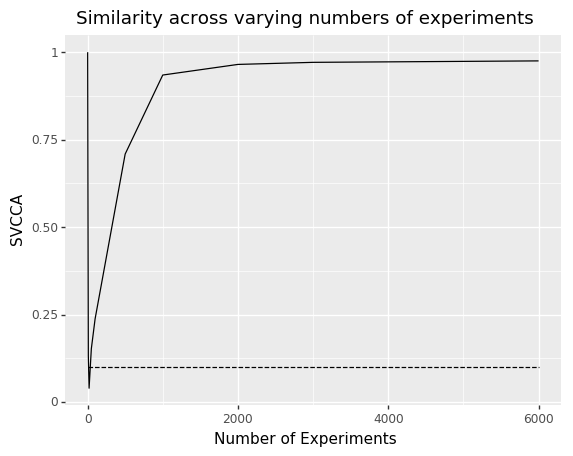

<ggplot: (-9223363307693704248)>

In [12]:
# Plot
threshold = pd.DataFrame(
    pd.np.tile(
        permuted_score,
        (len(lst_num_experiments), 1)),
    index=lst_num_experiments,
    columns=['score'])

ggplot(similarity_score_df, aes(x=lst_num_experiments, y='score')) \
    + geom_line() \
    + geom_line(aes(x=lst_num_experiments, y='score'), threshold, linetype='dashed') \
    + xlab('Number of Experiments') \
    + ylab('SVCCA') \
    + ggtitle('Similarity across varying numbers of experiments')